# **Divide2Conquer (D2C)**
This notebook contains the code and implementation details (for Facial Expression Recognition using FER2013 dataset in this case) on our proposed method, **Divide2Conquer (D2C)** to address the issue of **Overfitting** in Deep Learning models. We propose partitioning the training data into multiple subsets and training separate identical models on them. To avoid overfitting on any specific subset, the trained parameters from these models are aggregated and scaled periodically throughout the training phase, enabling the model to learn from the entire dataset while mitigating the impact of individual outliers or noise.

## **Importing Necessary Packages & Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import random
import cv2
import os
import sys
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, accuracy_score

sys.path.append('/content/drive/MyDrive/IAR Research Grant/Codes/Refined Codes')
from d2c_utils import *

## **Loading Dataset & Data Preprocessing**

In [ ]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir,
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):

        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        #im_gray_resized = cv2.resize(im_gray, (48,48), interpolation = cv2.INTER_AREA)
        #image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]

        # scale the image to [0, 1] and add to list
        data.append(im_gray/255)
        labels.append(label)

        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))

    # return a tuple of the data and labels
    return data, labels

In [ ]:
!unzip "/content/FER.zip" -d "/content/"

In [ ]:
#declare path to the data folder
img_path ='/content/train'

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply our function
image_list, label_list = load(image_paths, verbose=1000)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

#split data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(image_list,
                                                    label_list,
                                                    test_size=0.1,
                                                    random_state=7)

[INFO] processed 1000/28709
[INFO] processed 2000/28709
[INFO] processed 3000/28709
[INFO] processed 4000/28709
[INFO] processed 5000/28709
[INFO] processed 6000/28709
[INFO] processed 7000/28709
[INFO] processed 8000/28709
[INFO] processed 9000/28709
[INFO] processed 10000/28709
[INFO] processed 11000/28709
[INFO] processed 12000/28709
[INFO] processed 13000/28709
[INFO] processed 14000/28709
[INFO] processed 15000/28709
[INFO] processed 16000/28709
[INFO] processed 17000/28709
[INFO] processed 18000/28709
[INFO] processed 19000/28709
[INFO] processed 20000/28709
[INFO] processed 21000/28709
[INFO] processed 22000/28709
[INFO] processed 23000/28709
[INFO] processed 24000/28709
[INFO] processed 25000/28709
[INFO] processed 26000/28709
[INFO] processed 27000/28709
[INFO] processed 28000/28709


In [ ]:
#declare path to your test data folder
test_img_path = '/content/test'

#get the path list using the path object
test_image_paths = list(paths.list_images(test_img_path))

#apply our function
test_image_list, test_label_list = load(test_image_paths, verbose=1000)

#binarize the labels
lb = LabelBinarizer()
test_label_list = lb.fit_transform(test_label_list)

X_Test, y_Test = test_image_list, test_label_list
X_Test = tf.stack(X_Test)
y_Test = tf.stack(y_Test)

[INFO] processed 1000/7178
[INFO] processed 2000/7178
[INFO] processed 3000/7178
[INFO] processed 4000/7178
[INFO] processed 5000/7178
[INFO] processed 6000/7178
[INFO] processed 7000/7178


## **Defining Necessary Functions**

In [ ]:
def create_subsets(image_list, label_list, num_subsets=3, initial='subset'):
    ''' return: a dictionary with keys subset names and value as
                data shards - tuple of sequence and label lists.
        args:
            image_list: a list of numpy arrays of inputs
            label_list:a list of binarized labels for each sequence
            num_subsets: number of training subsets
            initials: the subset name prefix, e.g, subset_1

    '''

    #create a list of subset no.
    subset_no = ['{}_{}'.format(initial, i+1) for i in range(num_subsets)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each subset
    size = len(data)//num_subsets
    shards = [data[i:i + size] for i in range(0, size*num_subsets, size)]

    #number of subsets must equal number of shards
    assert(len(shards) == len(subset_no))

    return {subset_no[i] : shards[i] for i in range(len(subset_no))}

In [ ]:
def batch_data(data_shard, bs=32):
    '''Takes in a subsets' data shard and creates a tfds object off it
    args:
        shard: a data, label constituting a subsets' data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

# **Setting Hyperparameter Values**
The new global hyperparameters that need tuning, in this case, are the **Number of Subsets of the Training Set** and the **Number of Epochs before each round of Global Averaging**. To refer to them concisely, we will use the variables **N** and **E** respectively.

In [ ]:
# Setting the Number of Subsets of the Training Set, N
N = 3

# Setting the Number of Epochs before each round of Global Averaging, E
E = 1

In [ ]:
#create subsets
subsets = create_subsets(training_sequences, y_train, num_subsets=N, initial='subset')

In [ ]:
#process and batch the training data for each subset
subsets_batched = dict()
for (subset_no, data) in subsets.items():
    subsets_batched[subset_no] = batch_data(data)

#process and batch the train set
train_batched = tf.data.Dataset.from_tensor_slices((training_sequences, y_train)).batch(len(y_train))
#process and batch the validation set
val_batched = tf.data.Dataset.from_tensor_slices((val_sequences, y_val)).batch(len(y_val))

# **Constructing the Deep Learning Model**
The Network Architecture is shown in the picture below..
<div style="text-align: center;">
    <img src="CNN_Horizontal.png" alt="The CNN based Model" width="1200"/>
</div>

In [ ]:
class CNNModel:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.1))
        model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.3))
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        #model.add(Activation("softmax"))
        return model

In [ ]:
lr = 0.001
comms_round = 80 # Number of Global Epochs
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, epsilon=0.001, amsgrad=True)

Accu = []
Loss = []
Tr_Accu = []
Tr_Loss =[]

# **Training The Subset Models And Central Averaging**
The whole process is summarized in the picture below..
<div style="text-align: center;">
    <img src="D2C_Method.png" alt="D2C Method at a Glance" width="600"/>
</div>

In [ ]:
#initialize central model
mcnn_central = CNNModel()
central_model = mcnn_central.build((48, 48, 1), 7)
best_model = mcnn_central.build((48, 48, 1), 7)

#commence global training loop
for comm_round in range(comms_round):

    # get the Central model's weights - will serve as the initial weights for all Subset models
    central_weights = central_model.get_weights()

    #initial list to collect subset model weights after scalling
    scaled_subset_weight_list = list()

    #randomize subset data - using keys
    subsets = list(subsets_batched.keys())
    random.shuffle(subsets)

    #loop through each subset and create new subset model
    for subset in subsets:
        mcnn_subset = CNNModel()
        subset_model = mcnn_subset.build((48, 48, 1), 7)
        subset_model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)

        #set subset model weight to the weight of the Central model
        subset_model.set_weights(central_weights)

        #fit subset model with subset's data
        subset_model.fit(subsets_batched[subset], epochs=E, verbose=0)

        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(subsets_batched, subset)
        scaled_weights = scale_model_weights(subset_model.get_weights(), scaling_factor)
        scaled_subset_weight_list.append(scaled_weights)

        #clear session to free memory after each global epoch
        K.clear_session()

    #to get the average over all the subset models, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_subset_weight_list)

    #update Central model
    central_model.set_weights(average_weights)

    #test Central model and print out metrics after each global epoch
    for(X_train, y_train) in train_batched:
        central_train_acc, central_train_loss = test_train_model(X_train, y_train, central_model, comm_round)
        Tr_Accu.append(central_train_acc)
        Tr_Loss.append(central_train_loss)
    for(X_val, y_val) in val_batched:
        central_acc, central_loss = test_model(X_val, y_val, central_model, comm_round)
        Accu.append(central_acc)
        Loss.append(central_loss)

    if central_acc == max(Accu):
        best_model.set_weights(average_weights)

808/808 [==============================] - 2s 3ms/step
comm_round: 0 | global_training_acc: 25.110% | global_training_loss: 1.8602049350738525
90/90 [==============================] - 1s 6ms/step
comm_round: 0 | global_acc: 25.322% | global_loss: 1.8447695970535278
808/808 [==============================] - 2s 2ms/step
comm_round: 1 | global_training_acc: 25.110% | global_training_loss: 1.8430655002593994
90/90 [==============================] - 0s 2ms/step
comm_round: 1 | global_acc: 25.322% | global_loss: 1.8213444948196411
808/808 [==============================] - 2s 2ms/step
comm_round: 2 | global_training_acc: 32.069% | global_training_loss: 1.6843973398208618
90/90 [==============================] - 0s 2ms/step
comm_round: 2 | global_acc: 31.243% | global_loss: 1.6655138731002808
808/808 [==============================] - 2s 2ms/step
comm_round: 3 | global_training_acc: 42.043% | global_training_loss: 1.4763715267181396
90/90 [==============================] - 0s 2ms/step
comm_r

# **Model Validation**

90/90 [==============================] - 0s 2ms/step


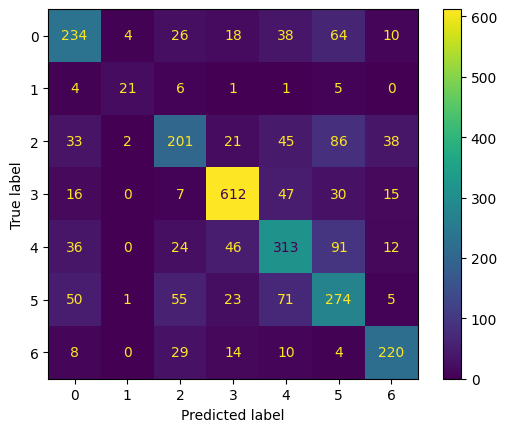

In [ ]:
pred = tf.nn.softmax(best_model.predict(X_val))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_val, axis=1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

In [ ]:
y_pred_proba = tf.nn.softmax(best_model.predict(X_val))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)

90/90 [==============================] - 0s 2ms/step
ROC_AUC Score: 0.8982006816790434
Cohen_Kappa Score: 0.5784882975326778
F1 Score: 0.6396218527905692
Matthews Correlation Coefficient: 0.5790135934383724
Log Loss: 1.44968094345754
Accuracy: 0.6530825496342738


Text(0, 0.5, 'Loss')

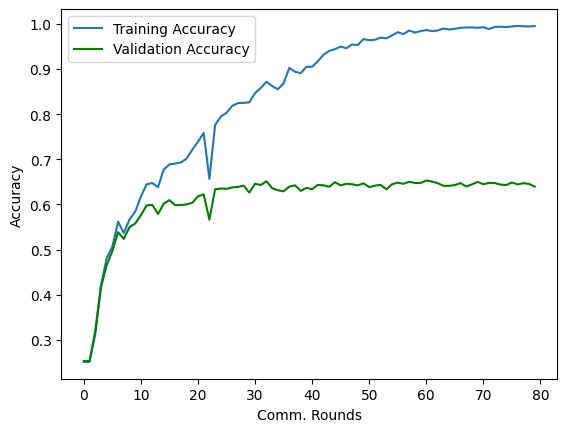

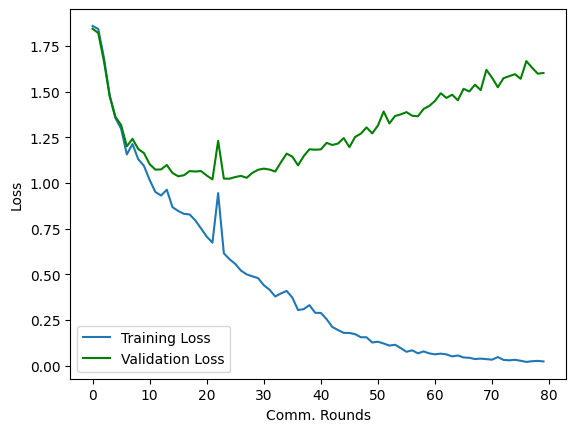

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = Tr_Accu
val_acc  = Accu
loss     = Tr_Loss
val_loss = Loss

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc, color = 'g')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss, color = 'g' )
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Loss')

# **Test Set Evaluation**

225/225 [==============================] - 1s 2ms/step


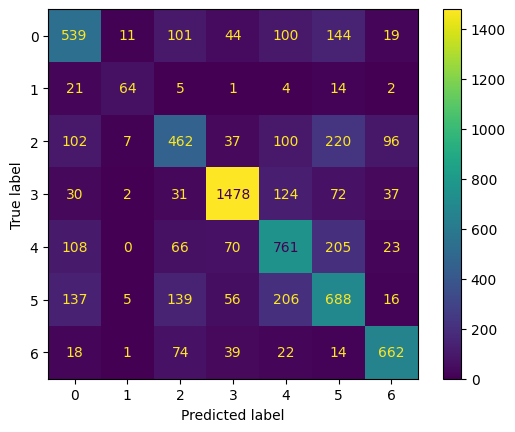

225/225 [==============================] - 1s 2ms/step
ROC_AUC Score: 0.8998772702596881
Cohen_Kappa Score: 0.5749350280497181
F1 Score: 0.6345690268522197
Matthews Correlation Coefficient: 0.5752320258514988
Log Loss: 1.4549897749128982
Accuracy: 0.6484603594816776


In [ ]:
pred = tf.nn.softmax(best_model.predict(X_Test))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_Test, axis = 1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

y_pred_proba = tf.nn.softmax(best_model.predict(X_Test))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)

# **Changing the Hyperparameters**

In [ ]:
# Setting the Number of Subsets of the Training Set, N
N = 2

# Setting the Number of Epochs before each round of Global Averaging, E
E = 2

In [ ]:
#create subsets
subsets = create_subsets(training_sequences, y_train, num_subsets=N, initial='subset')

In [ ]:
#process and batch the training data for each subset
subsets_batched = dict()
for (subset_no, data) in subsets.items():
    subsets_batched[subset_no] = batch_data(data)

#process and batch the train set
train_batched = tf.data.Dataset.from_tensor_slices((training_sequences, y_train)).batch(len(y_train))
#process and batch the validation set
val_batched = tf.data.Dataset.from_tensor_slices((val_sequences, y_val)).batch(len(y_val))

In [ ]:
lr = 0.001
comms_round = 50
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, epsilon=0.001, amsgrad=True)

Accu = []
Loss = []
Tr_Accu = []
Tr_Loss =[]

In [ ]:
#initialize central model
mcnn_central = CNNModel()
central_model = mcnn_central.build((48, 48, 1), 7)
best_model = mcnn_central.build((48, 48, 1), 7)

#commence global training loop
for comm_round in range(comms_round):

    # get the Central model's weights - will serve as the initial weights for all Subset models
    central_weights = central_model.get_weights()

    #initial list to collect subset model weights after scalling
    scaled_subset_weight_list = list()

    #randomize subset data - using keys
    subsets = list(subsets_batched.keys())
    random.shuffle(subsets)

    #loop through each subset and create new subset model
    for subset in subsets:
        mcnn_subset = CNNModel()
        subset_model = mcnn_subset.build((48, 48, 1), 7)
        subset_model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)

        #set subset model weight to the weight of the Central model
        subset_model.set_weights(central_weights)

        #fit subset model with subset's data
        subset_model.fit(subsets_batched[subset], epochs=E, verbose=0)

        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(subsets_batched, subset)
        scaled_weights = scale_model_weights(subset_model.get_weights(), scaling_factor)
        scaled_subset_weight_list.append(scaled_weights)

        #clear session to free memory after each global epoch
        K.clear_session()

    #to get the average over all the subset models, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_subset_weight_list)

    #update Central model
    central_model.set_weights(average_weights)

    #test Central model and print out metrics after each global epoch
    for(X_train, y_train) in train_batched:
        central_train_acc, central_train_loss = test_train_model(X_train, y_train, central_model, comm_round)
        Tr_Accu.append(central_train_acc)
        Tr_Loss.append(central_train_loss)
    for(X_val, y_val) in val_batched:
        central_acc, central_loss = test_model(X_val, y_val, central_model, comm_round)
        Accu.append(central_acc)
        Loss.append(central_loss)

    if central_acc == max(Accu):
        best_model.set_weights(average_weights)

808/808 [==============================] - 2s 2ms/step
comm_round: 0 | global_training_acc: 25.017% | global_training_loss: 1.9061280488967896
90/90 [==============================] - 0s 2ms/step
comm_round: 0 | global_acc: 26.158% | global_loss: 1.885066270828247
808/808 [==============================] - 2s 2ms/step
comm_round: 1 | global_training_acc: 32.568% | global_training_loss: 1.7108885049819946
90/90 [==============================] - 0s 2ms/step
comm_round: 1 | global_acc: 33.473% | global_loss: 1.7016303539276123
808/808 [==============================] - 2s 2ms/step
comm_round: 2 | global_training_acc: 47.419% | global_training_loss: 1.2912110090255737
90/90 [==============================] - 0s 2ms/step
comm_round: 2 | global_acc: 46.813% | global_loss: 1.3107424974441528
808/808 [==============================] - 2s 2ms/step
comm_round: 3 | global_training_acc: 54.846% | global_training_loss: 1.1469911336898804
90/90 [==============================] - 0s 3ms/step
comm_ro

90/90 [==============================] - 0s 2ms/step


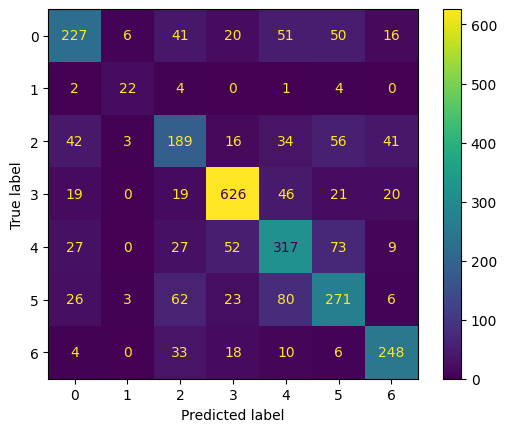

In [ ]:
pred = tf.nn.softmax(best_model.predict(X_val))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_val, axis=1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

In [ ]:
y_pred_proba = tf.nn.softmax(best_model.predict(X_val))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)

90/90 [==============================] - 0s 3ms/step
ROC_AUC Score: 0.9092865137475518
Cohen_Kappa Score: 0.5889388623931997
F1 Score: 0.6451807533820448
Matthews Correlation Coefficient: 0.5891930346152131
Log Loss: 1.7563987352113586
Accuracy: 0.6617903169627307


Text(0, 0.5, 'Loss')

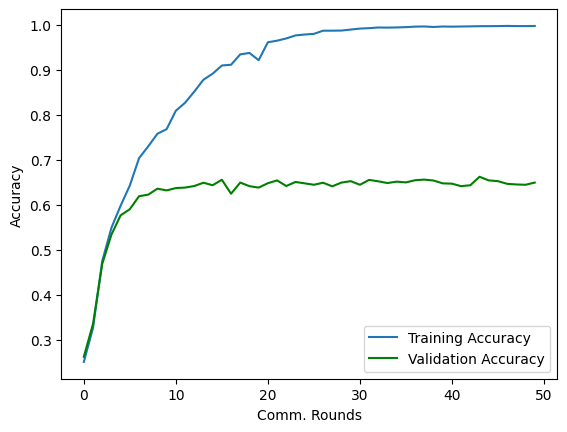

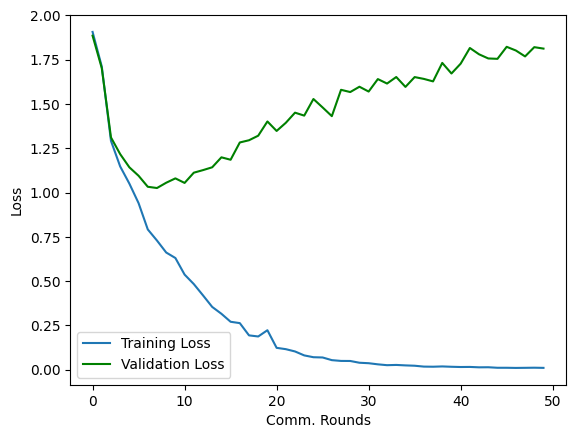

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = Tr_Accu
val_acc  = Accu
loss     = Tr_Loss
val_loss = Loss

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc, color = 'g')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Accuracy')

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss, color = 'g' )
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Loss')

# **Test Set**

225/225 [==============================] - 1s 2ms/step


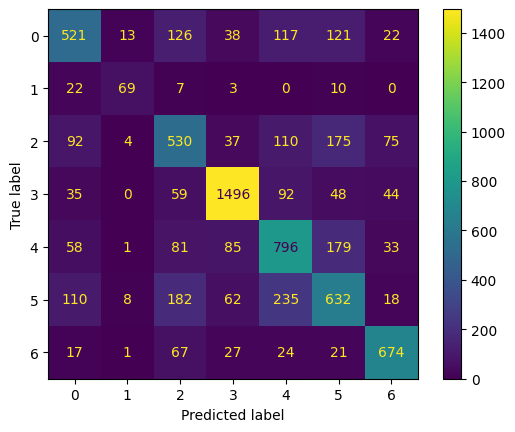

225/225 [==============================] - 1s 2ms/step
ROC_AUC Score: 0.9030344123351004
Cohen_Kappa Score: 0.5858163533401604
F1 Score: 0.6466135916715495
Matthews Correlation Coefficient: 0.5860721670913133
Log Loss: 1.8237374454463375
Accuracy: 0.6573777344294274


In [ ]:
pred = tf.nn.softmax(best_model.predict(X_Test))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_Test, axis = 1)
Confusion_Matrix = confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

y_pred_proba = tf.nn.softmax(best_model.predict(X_Test))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)